### Plotting Viral Load

In this example, we will show how to plot wastewater viral load and clinical test positivity. Before starting make sure the Python-outbreak-data package is up-to-date and import all necessary plotting and data analysis packages. Here are the ones we used for this plot:

In [ ]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)

In [ ]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools

In [3]:
from outbreak_data import authenticate_user
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/STRJTZOPBAYSZAJJDZRVPSQVPCWHNIFBAMRBPHKFIGVERDQVKTKHUBHZEJYOOZUOAJMCGOFLAFDCJPMJKYMPFMJBUCOVSJHLXRRHJMHBXBLOYBRQJBCNCCBDHKUMBELY
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Database Access
    Agreement;
    2. You will not distribute, or re-distribute Data made available through
    GIS

First we specifiy the location and time of data collection. We're going to use wastewater samples taken in the state of Ohio collected over a 3 month period. 

In [ ]:
state = "Ohio"
state_id = 'USA_US-OH'
startdate, enddate = "2023-07-02", "2023-10-02"

These functions are highly recommended to ensure smooth plotting of the data.

In [ ]:
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])

def lognorm_ci(x, r):
    return (np.exp(np.log(x)-(r**0.5/x)), np.exp(np.log(x)+(r**0.5/x)))

smooth = binom_kernel(7*5, 35)

Now we'll go ahead and query for wastewater data using our defined specifications. After this, we'll need to organize our retrieved sample data by date and site_id within our specified region to get the viral load smaple data. At this point, we are filtering out viral load information from sites with few samples. Then we normalize each site's viral load signals to have a variance of 1.

In [ ]:
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info') #Retrieve sample data

samples_per_site = ww_samples['sra_accession'].groupby(ww_samples['collection_site_id']).nunique()

date_range_per_site = ww_samples.index.to_series().apply(pd.to_datetime).groupby(ww_samples['collection_site_id']) #.apply(pd.to_datetime)
date_range_per_site = date_range_per_site.apply(lambda x: x.max() - x.min())

sites_for_vl = (date_range_per_site.apply(lambda x: x.days >= 14)) & (samples_per_site >= 3)
samples_for_vl = ww_samples[ww_samples['collection_site_id'].isin(list(sites_for_vl.index[sites_for_vl]))]

Fetch and aggregate the weekly and unsmooothed viral load sample data.

In [10]:
viral_load = samples_for_vl.set_index(pd.Series(['viral_load'] * len(samples_for_vl)), append=True)
c = 'normed_viral_load'
viral_load_unsmoothed = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='D', column=c, norm=False, rolling=1, log=False)
viral_load_weekly, viral_load_weekly_varis = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='7D', column=c, norm=False, rolling=[1,4,1], log=False, variance=True)
viral_load, viral_load_varis = outbreak_tools.datebin_and_agg(viral_load, weights=viral_load['ww_population'].fillna(1000), startdate=startdate, enddate=enddate, freq='D', column=c, norm=False, rolling=smooth, log=False, variance=True)

viral_load_unsmoothed = viral_load_unsmoothed['viral_load']
viral_load_weekly = viral_load_weekly['viral_load']
viral_load_weekly_varis = viral_load_weekly_varis['viral_load']
viral_load = viral_load['viral_load']
viral_load_varis = viral_load_varis['viral_load']

Download and aggregate the clinical test positivity data. Positivity is defined as the number of positive tests divided by the total number of tests.

In [20]:
state_cases = pd.read_csv('https://data.chhs.ca.gov/datastore/dump/a3b94dd4-b866-4208-a811-980ed497d1d1?bom=True')

s = state_cases.set_index('date').set_index(pd.Series(['clinical'] * len(state_cases)), append=True)
s['positivity'] = s['positive_tests'] / s['total_tests']
su = outbreak_tools.datebin_and_agg(s, column='positivity', weights=s['total_tests'], startdate=startdate, enddate=enddate, freq='D', norm=False, rolling=1, log=False)
s, sv = outbreak_tools.datebin_and_agg(s, column='positivity', weights=s['total_tests'], startdate=startdate, enddate=enddate, freq='D', norm=False, rolling=7, log=False, variance=True)

Finally, we plot the data.

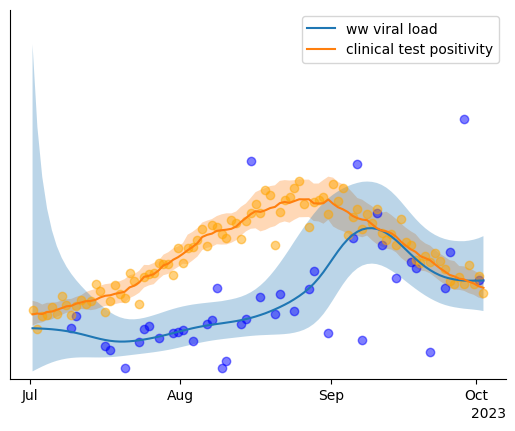

In [21]:
_,ax = plt.subplots()

l,u = lognorm_ci(viral_load, viral_load_varis)
ax.plot(viral_load.index.mid, viral_load / viral_load.std(), label='ww viral load')
ax.fill_between(viral_load.index.mid, l / viral_load.std(), u / viral_load.std(), alpha=0.3)
ax.scatter(viral_load_unsmoothed.index.mid, viral_load_unsmoothed / viral_load.std(), color='blue', alpha=0.5)

l,u = lognorm_ci(s['clinical'], sv['clinical'])
ax.plot(s.index.mid, s['clinical'] / s['clinical'].std(), label='clinical test positivity')
ax.fill_between(s.index.mid, l / s['clinical'].std(), u / s['clinical'].std(), alpha=0.3, zorder=-1)
ax.scatter(su.index.mid, su / s['clinical'].std(), color='orange', alpha=0.5)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylim(0, 10)

ax.set_yticks([])

plt.legend()
plt.show()

# ax.set_title('')
# plot_out('viral_load_comparison.pdf')
